In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"atharvamusale","key":"db125aeaccb7099d9c72f7d68f64551a"}'}

In [ ]:
!mkdir ~/.kaggle


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!chmod 600 kaggle.json

In [ ]:
!cp kaggle.json ~/.kaggle

In [ ]:
!rm kaggle.json

In [ ]:
pip install -q kaggle

In [ ]:
!ls -a

.  ..  .config	sample_data


In [ ]:
!kaggle competitions download -c aptos2019-blindness-detection

100% 7.99G/8.01G [02:02<00:00, 55.2MB/s]
100% 8.01G/8.01G [02:02<00:00, 70.4MB/s]
100% 1.50G/1.50G [00:23<00:00, 90.8MB/s]
100% 1.50G/1.50G [00:23<00:00, 68.5MB/s]
  0% 0.00/53.7k [00:00<?, ?B/s]
100% 53.7k/53.7k [00:00<00:00, 55.5MB/s]
  0% 0.00/24.5k [00:00<?, ?B/s]
100% 24.5k/24.5k [00:00<00:00, 21.0MB/s]
  0% 0.00/28.3k [00:00<?, ?B/s]
100% 28.3k/28.3k [00:00<00:00, 29.7MB/s]


In [ ]:
!unzip train_images.zip
!unzip test_images.zip

Archive:  train_images.zip
  inflating: 7b9d519cbd66.png        
  inflating: ae49cc60f251.png        
  inflating: b294927b14b0.png        
  inflating: f4d3777f2710.png        
  inflating: d74ccc796517.png        
  inflating: 15bed5adde74.png        
  inflating: f002ce614c59.png        
  inflating: 7335a2d43ada.png        
  inflating: 9b7b6e4db1d5.png        
  inflating: 1968183f0e61.png        
  inflating: d91273efb92a.png        
  inflating: 5cf9127f251a.png        
  inflating: 370f575adb23.png        
  inflating: 4c17e85686f0.png        
  inflating: 4f7755e74a9e.png        
  inflating: 25e9fd872182.png        
  inflating: b64e1eef3d63.png        
  inflating: e7d2c2c3b30f.png        
  inflating: bfda2fd0533a.png        
  inflating: 224bb938e2dd.png        
  inflating: d51e5d7484ea.png        
  inflating: dc6fa1b38b83.png        
  inflating: 74898f372d2b.png        
  inflating: 152db3de8120.png        
  inflating: 07929d32b5b3.png        
  inflating: 0773a1c326

In [ ]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from tqdm import tqdm

%matplotlib inline

In [ ]:
np.random.seed(2019)
tf.set_random_seed(2019)


In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
print(train_df.shape)
print(test_df.shape)
train_df.head()

(3662, 2)
(1928, 1)


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

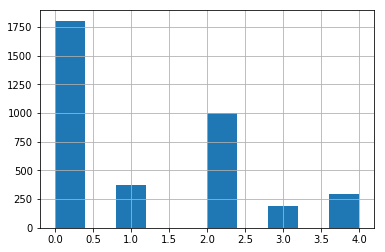

In [ ]:
train_df['diagnosis'].hist()
train_df['diagnosis'].value_counts()

In [ ]:
def get_pad_width(im, new_shape, is_rgb=True):
    pad_diff = new_shape - im.shape[0], new_shape - im.shape[1]
    t, b = math.floor(pad_diff[0]/2), math.ceil(pad_diff[0]/2)
    l, r = math.floor(pad_diff[1]/2), math.ceil(pad_diff[1]/2)
    if is_rgb:
        pad_width = ((t,b), (l,r), (0, 0))
    else:
        pad_width = ((t,b), (l,r))
    return pad_width

def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    
    return im

In [ ]:
!pwd

/content


In [ ]:
N = train_df.shape[0]
x_train = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image(
        f'../content/{image_id}.png'
    )

100%|██████████| 3662/3662 [09:48<00:00,  5.45it/s]


In [ ]:
N = test_df.shape[0]
x_test = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(test_df['id_code'])):
    x_test[i, :, :, :] = preprocess_image(
        f'../content/{image_id}.png'
    )

100%|██████████| 1928/1928 [01:46<00:00, 18.18it/s]


In [ ]:
y_train = pd.get_dummies(train_df['diagnosis']).values

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(3662, 224, 224, 3)
(3662, 5)
(1928, 224, 224, 3)


In [ ]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [1805  370  999  193  295]
Multilabel version: [3662 1857 1487  488  295]


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train_multi, 
    test_size=0.15, 
    random_state=2019
)

In [ ]:
class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y

In [ ]:
BATCH_SIZE = 32

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Using original generator
data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2019)
# Using Mixup
mixup_generator = MixupGenerator(x_train, y_train, batch_size=BATCH_SIZE, alpha=0.2, datagen=create_datagen())()

In [ ]:
true_labels = np.array([1, 0, 1, 1, 0, 1])
pred_labels = np.array([1, 0, 0, 0, 0, 1])

In [ ]:
true_labels = np.array([1, 0, 1, 1, 0, 1])


In [ ]:
cohen_kappa_score(true_labels, pred_labels)

0.3999999999999999

In [ ]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')

        return

In [ ]:
densenet = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=None
)









29089792/29084464 [==============================] - 3s 0us/step


In [ ]:
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    
    return model

In [ ]:
model = build_model()
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
kappa_metrics = Metrics()

history = model.fit_generator(
    data_generator,
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=15,
    validation_data=(x_val, y_val),
    callbacks=[kappa_metrics]
)

Epoch 1/15
98/97 [==============================] - 132s 1s/step - loss: 0.4444 - acc: 0.7906 - val_loss: 0.2530 - val_acc: 0.9269
val_kappa: 0.8415
Validation Kappa has improved. Saving model.
Epoch 2/15
98/97 [==============================] - 92s 940ms/step - loss: 0.2125 - acc: 0.9218 - val_loss: 0.1526 - val_acc: 0.9491
val_kappa: 0.8602
Validation Kappa has improved. Saving model.
Epoch 3/15
98/97 [==============================] - 92s 939ms/step - loss: 0.1654 - acc: 0.9378 - val_loss: 0.1371 - val_acc: 0.9524
val_kappa: 0.8669
Validation Kappa has improved. Saving model.
Epoch 4/15
98/97 [==============================] - 92s 939ms/step - loss: 0.1385 - acc: 0.9471 - val_loss: 0.1184 - val_acc: 0.9553
val_kappa: 0.8804
Validation Kappa has improved. Saving model.
Epoch 5/15
98/97 [==============================] - 92s 938ms/step - loss: 0.1289 - acc: 0.9514 - val_loss: 0.1339 - val_acc: 0.9465
val_kappa: 0.8455
Epoch 6/15
98/97 [==============================] - 92s 938ms/step 

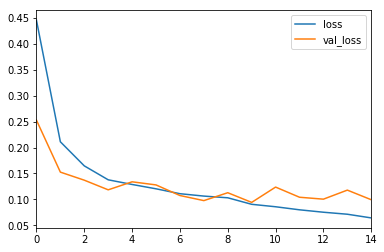

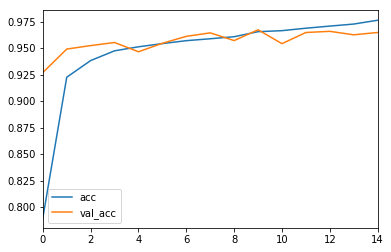

In [ ]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

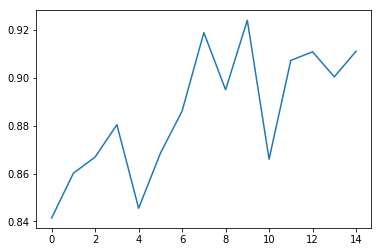

In [ ]:
plt.plot(kappa_metrics.val_kappas)

In [ ]:
model.load_weights('model.h5')
y_val_pred = model.predict(x_val)

def compute_score_inv(threshold):
    y1 = y_val_pred > threshold
    y1 = y1.astype(int).sum(axis=1) - 1
    y2 = y_val.sum(axis=1) - 1
    score = cohen_kappa_score(y1, y2, weights='quadratic')
    
    return 1 - score

simplex = scipy.optimize.minimize(
    compute_score_inv, 0.5, method='nelder-mead'
)

best_threshold = simplex['x'][0]

In [ ]:
y_test = model.predict(x_test) > 0.5
y_test = y_test.astype(int).sum(axis=1) - 1

test_df['diagnosis'] = y_test
test_df.to_csv('submission.csv',index=False)

In [ ]:
data=pd.read_csv('submission.csv')

In [ ]:
data

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,2
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2
5,009c019a7309,2
6,010d915e229a,3
7,0111b949947e,0
8,01499815e469,3
9,0167076e7089,0
